In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet

train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])
holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])
stores = pd.read_csv('stores.csv')


In [14]:
print("train", train.shape)
print("test", test.shape)
print("holidays", holidays.shape)
print("stores", stores.shape)

train =train.dropna(subset=['sales', 'onpromotion'])


train (3000888, 6)
test (28512, 5)
holidays (350, 6)
stores (54, 5)


In [15]:
datasets = {
    'train': train,
    'test': test,
    'holidays': holidays,
    'stores': stores
}
for name, df in datasets.items():
  print(df.isnull().sum())

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


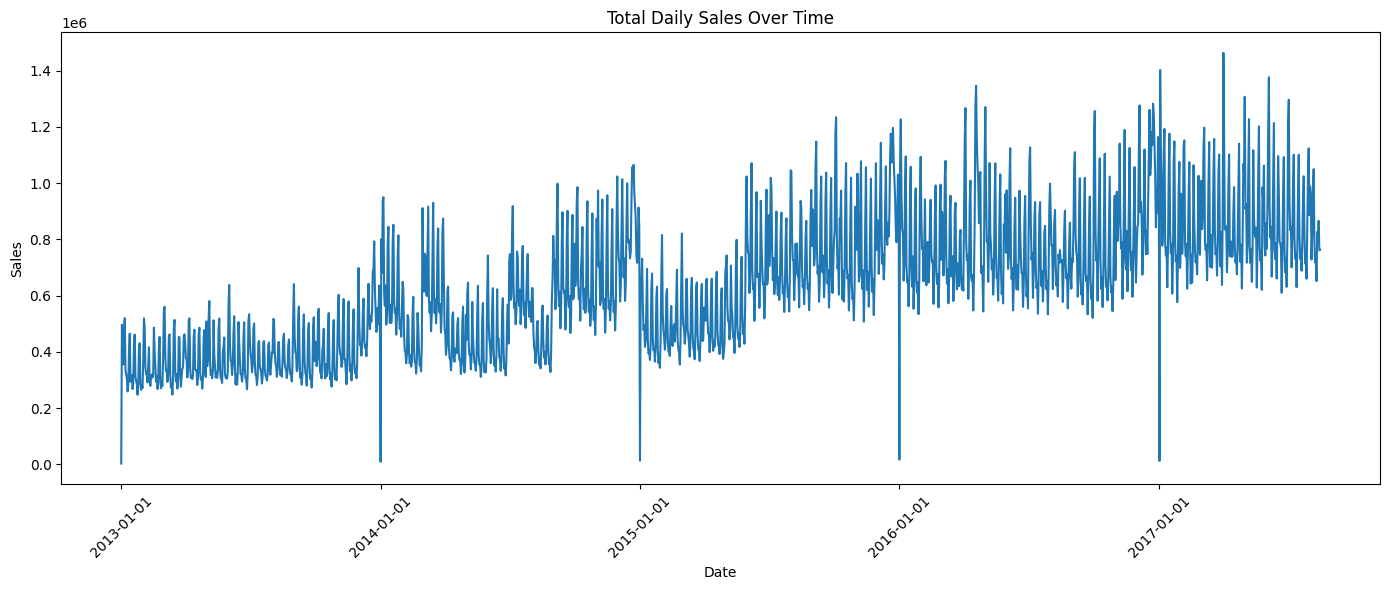

In [16]:
daily_sales = train.groupby('date')['sales'].sum().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title("Total Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)

# Format x-axis date labels
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())


plt.tight_layout()
plt.show()

In [17]:
store_id = 1
family = 'BEVERAGES'

df = train[(train['store_nbr'] == store_id) & (train['family'] == family)].copy()
df_prophet = df[['date','sales']].rename(columns={'date':'ds', 'sales':'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6s2pmb99/5cr1zh_m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6s2pmb99/5n6yfx3e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68892', 'data', 'file=/tmp/tmp6s2pmb99/5cr1zh_m.json', 'init=/tmp/tmp6s2pmb99/5n6yfx3e.json', 'output', 'file=/tmp/tmp6s2pmb99/prophet_modelhgxdwk8_/prophet_model-20250702085019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:50:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:50:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


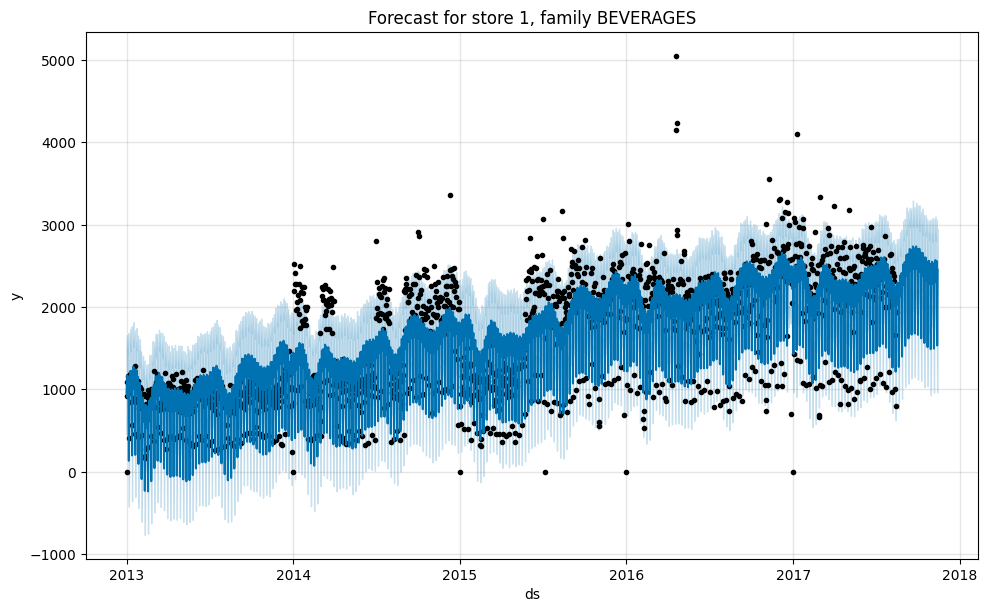

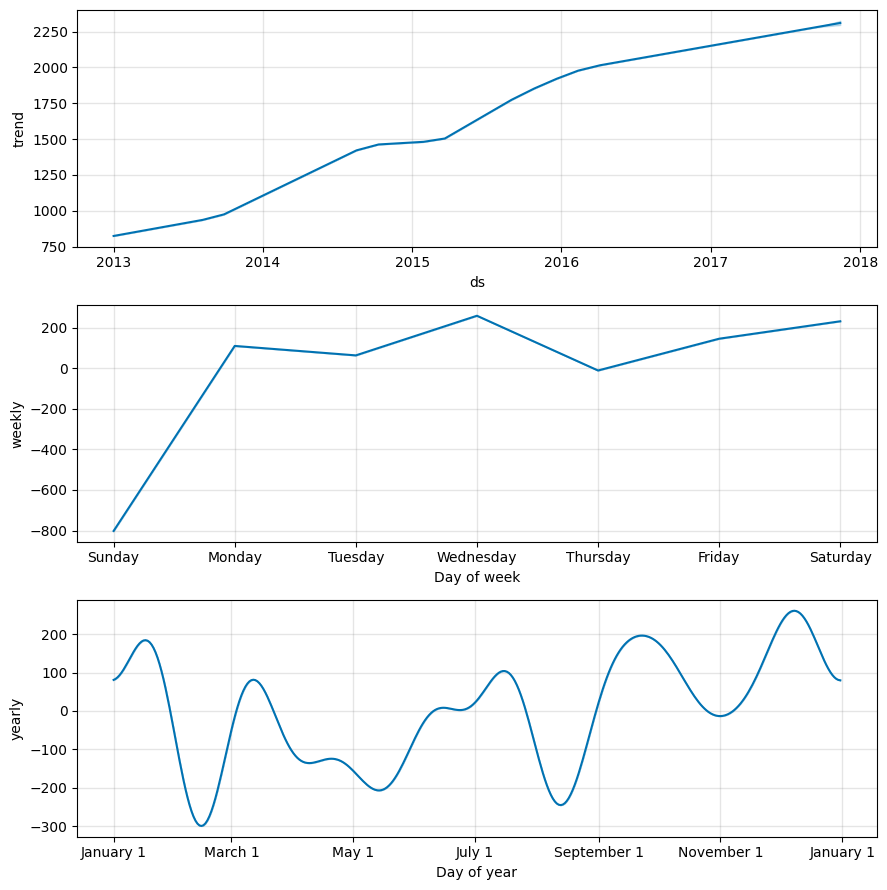

In [18]:
model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

model.plot(forecast)
plt.title(f'Forecast for store {store_id}, family {family}')
plt.show()

model.plot_components(forecast)
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Train/Test split (last 90 days)
cutoff = df_prophet['ds'].max() - pd.Timedelta(days=90)
train_data = df_prophet[df_prophet['ds'] <=cutoff]
valid_data = df_prophet[df_prophet['ds']> cutoff]

#train model on train_data only
model_val = Prophet()
model_val.fit(train_data)

#Forecast same 90-day period
future_val = model_val.make_future_dataframe(periods=90)
forecast_val = model_val.predict(future_val)

#Merge forecast and actual
predicted = forecast_val[['ds', 'yhat']].set_index('ds')
actual = valid_data.set_index('ds')
comparison = actual.join(predicted).dropna()
comparison = comparison[comparison['y'] != 0]
#Metrics
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
mae = mean_absolute_error(comparison['y'], comparison['yhat'])
mape = np.mean(np.abs((comparison['y'] - comparison['yhat']) / comparison['y'])) * 100

print(f"RMSE:{rmse:.2f}")
print(f"MAE:{mae:.2f}")
print(f"MAPE:{mape:.2f}%")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6s2pmb99/s57x0szw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6s2pmb99/2em3hods.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86403', 'data', 'file=/tmp/tmp6s2pmb99/s57x0szw.json', 'init=/tmp/tmp6s2pmb99/2em3hods.json', 'output', 'file=/tmp/tmp6s2pmb99/prophet_modelunw4pz5i/prophet_model-20250702085021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:50:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:50:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE:330.97
MAE:257.56
MAPE:15.43%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6s2pmb99/xh6xjc6_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6s2pmb99/1zzoptgc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45620', 'data', 'file=/tmp/tmp6s2pmb99/xh6xjc6_.json', 'init=/tmp/tmp6s2pmb99/1zzoptgc.json', 'output', 'file=/tmp/tmp6s2pmb99/prophet_modela32oiro8/prophet_model-20250702085022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:50:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:50:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


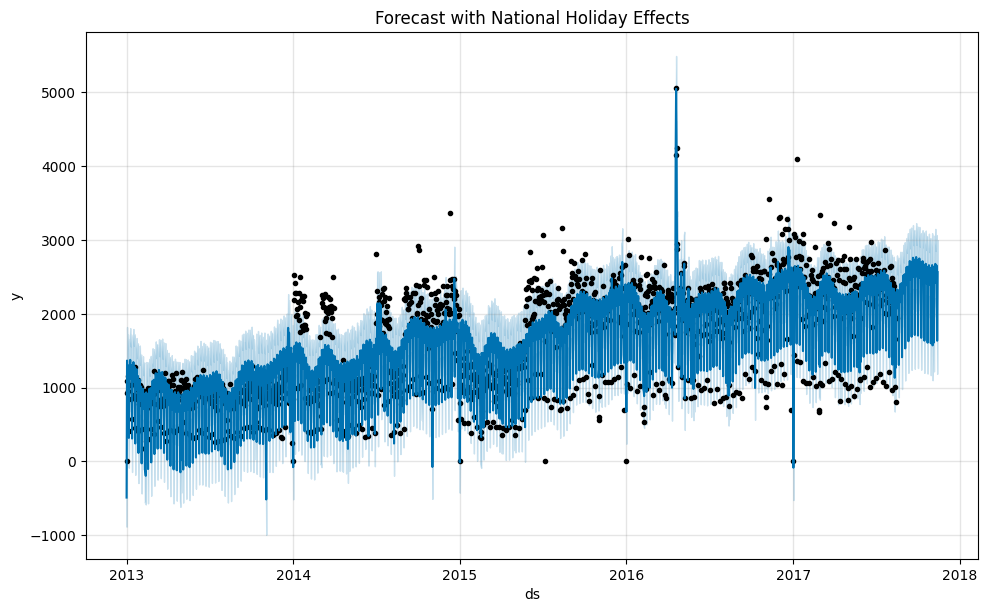

In [20]:
# Use only National holidays
holiday_df = holidays[holidays['locale'] == 'National'][['date', 'description']]
holiday_df = holiday_df.rename(columns={'date': 'ds', 'description': 'holiday'})

# Train with holidays
model_holiday = Prophet(holidays=holiday_df)
model_holiday.fit(df_prophet)

future = model_holiday.make_future_dataframe(periods=90)
forecast = model_holiday.predict(future)

# Plot with holiday effects
model_holiday.plot(forecast)
plt.title("Forecast with National Holiday Effects")
plt.show()


In [21]:
store_family_combos= train[['store_nbr', 'family']].drop_duplicates()


In [22]:
results = []

store_family_combos = store_family_combos.head(40)

for idx, row in store_family_combos.iterrows():
  store = row['store_nbr']
  family = row['family']

  df =train[(train['store_nbr']== store) & (train['family'] == family)].copy()

  if df['sales'].sum() == 0 or df.shape[0]<180:
    continue

  df['onpromotion'] =df['onpromotion'].fillna(0)
  df_prophet = df[['date', 'sales', 'onpromotion']].rename(columns={'date': 'ds', 'sales': 'y'})
  df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

  #Train/Test split
  cutoff = df_prophet['ds'].max() - pd.Timedelta(days=90)
  train_data = df_prophet[df_prophet['ds'] <= cutoff]
  valid_data = df_prophet[df_prophet['ds'] > cutoff]

  try:
        # Build model
        model = Prophet(holidays=holiday_df, yearly_seasonality=False)
        model.add_regressor('onpromotion')
        model.fit(train_data)

        # Prepare future
        future = model.make_future_dataframe(periods=90)
        future = future.merge(df_prophet[['ds', 'onpromotion']], on='ds', how='left')
        future['onpromotion'] = future['onpromotion'].fillna(0)

        # Forecast
        forecast = model.predict(future)

        # Join with actual
        predicted = forecast[['ds', 'yhat']].set_index('ds')
        actual = valid_data.set_index('ds')
        comparison = actual.join(predicted).dropna()
        comparison = comparison[comparison['y'] != 0]

        # Metrics
        rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
        mae = mean_absolute_error(comparison['y'], comparison['yhat'])
        mape = np.mean(np.abs((comparison['y'] - comparison['yhat']) / comparison['y'])) * 100

        results.append({
            'store_nbr': store,
            'family': family,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape
          })

  except Exception as e:
    print(f" Skipped store {store}, family {family} due to error: {e}")
    continue

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6s2pmb99/8thrsu5g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6s2pmb99/qyb732ew.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53177', 'data', 'file=/tmp/tmp6s2pmb99/8thrsu5g.json', 'init=/tmp/tmp6s2pmb99/qyb732ew.json', 'output', 'file=/tmp/tmp6s2pmb99/prophet_modele84a9a3k/prophet_model-20250702085025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:50:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:50:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6s

⚠️ Skipped store 10, family BABY CARE due to error: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6s2pmb99/ry4oc1ja.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6s2pmb99/4a7axpa3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4158', 'data', 'file=/tmp/tmp6s2pmb99/ry4oc1ja.json', 'init=/tmp/tmp6s2pmb99/4a7axpa3.json', 'output', 'file=/tmp/tmp6s2pmb99/prophet_modeljl0s7o9h/prophet_model-20250702085110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:51:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:51:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6s2

In [23]:
results_df = pd.DataFrame(results)
results_df.sort_values(by='MAPE', ascending =False).head(10)  # Top 10 best forecasts


,store_nbr,family,RMSE,MAE,MAPE
20,1,LINGERIE,5.471753,4.168338,93.248609
5,1,CELEBRATION,7.939295,6.098542,87.793525
22,1,MAGAZINES,3.427795,2.886135,73.918443
30,1,SCHOOL AND OFFICE SUPPLIES,0.730322,0.730322,73.032154
36,10,CELEBRATION,2.658863,1.946360,70.659534
16,1,HOME APPLIANCES,1.293127,1.049933,67.695055
0,1,AUTOMOTIVE,2.922538,2.084036,67.068499
1,1,BEAUTY,1.885645,1.453310,65.227231
26,1,PLAYERS AND ELECTRONICS,3.931569,3.240561,63.995623
19,1,LAWN AND GARDEN,8.484267,7.166648,61.461616


In [25]:
results_df.to_csv("forecasting_metrics_by_store_family.csv", index=False)

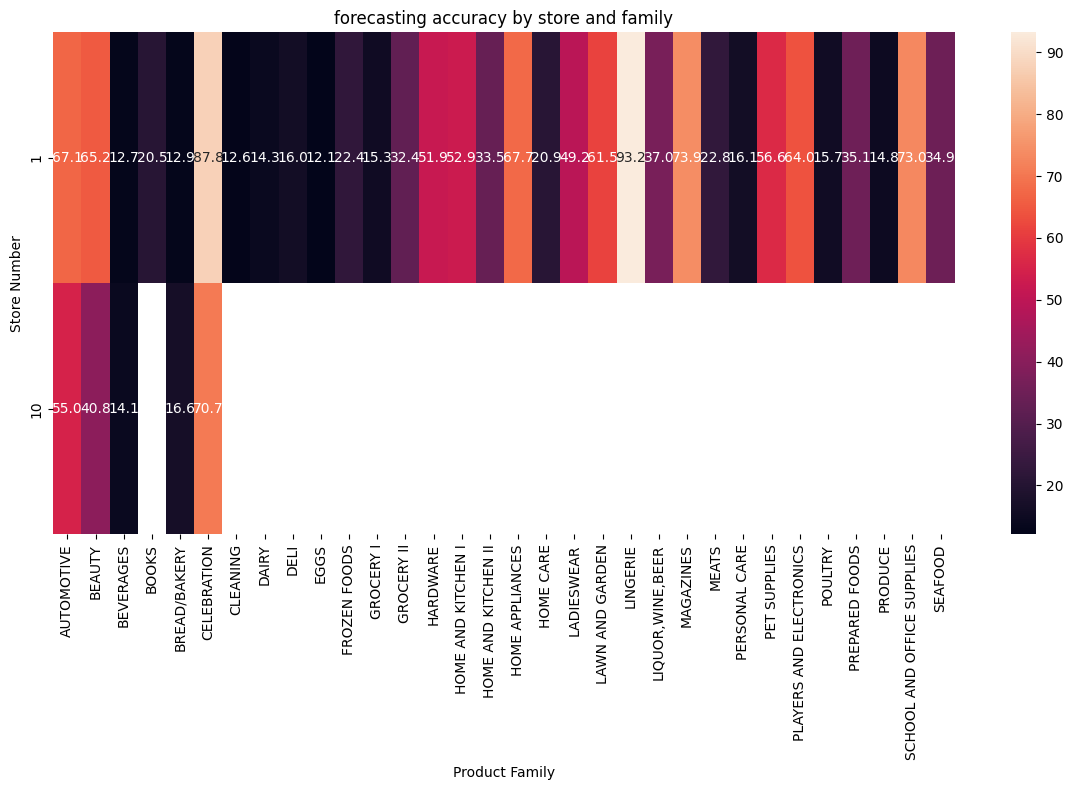

In [38]:
pivot = results_df.pivot_table(values='MAPE', index='store_nbr', columns='family')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, cmap=None, fmt=".1f")
plt.title("forecasting accuracy by store and family")
plt.xlabel("Product Family")
plt.ylabel("Store Number")
plt.tight_layout()
plt.show()